Link para o dataset: [Dataset temperaturas Melbourne](https://www.kaggle.com/datasets/samfaraday/daily-minimum-temperatures-in-me)

In [ ]:
# Instalar e configurar o Kaggle CLI
!pip install -q kaggle

# Criar a pasta e mover o JSON
import os
os.makedirs("/root/.kaggle", exist_ok=True)
import shutil
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
# Baixar o dataset com o link atualizado
!kaggle datasets download -d samfaraday/daily-minimum-temperatures-in-me

# Descompactar o arquivo
!unzip -q daily-minimum-temperatures-in-me.zip


Dataset URL: https://www.kaggle.com/datasets/samfaraday/daily-minimum-temperatures-in-me
License(s): Community Data License Agreement - Permissive - Version 1.0


In [ ]:
import pandas as pd

# Ler o CSV ignorando linhas com erro de formatação
df = pd.read_csv("daily-minimum-temperatures-in-me.csv", on_bad_lines='skip')

# Mostrar as primeiras linhas
df.head()


,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
# Instalar o Prophet
!pip install -q prophet

In [ ]:
print(df.columns)


Index(['Date', 'Daily minimum temperatures in Melbourne, Australia, 1981-1990'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1t5gf81o/urejfywr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1t5gf81o/vf4573lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19867', 'data', 'file=/tmp/tmp1t5gf81o/urejfywr.json', 'init=/tmp/tmp1t5gf81o/vf4573lu.json', 'output', 'file=/tmp/tmp1t5gf81o/prophet_modelnzf_jhfb/prophet_model-20250325234608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


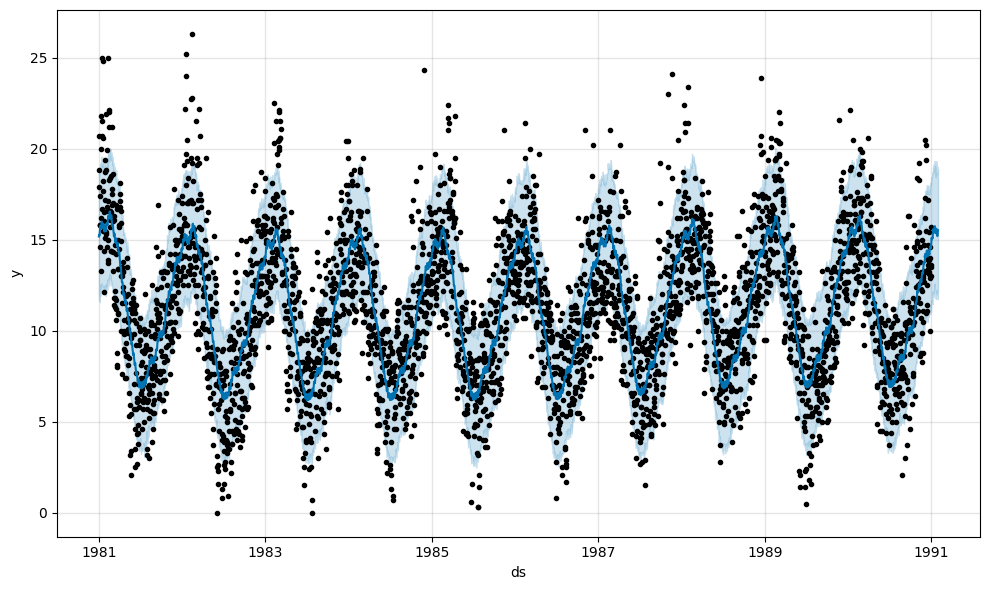

In [ ]:
# Renomear colunas
df.columns = ['Date', 'Temp']

# Forçar conversão da coluna Temp para float (valores inválidos viram NaN)
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Remover linhas com valores NaN (ocasionados por valores inválidos)
df = df.dropna()

# Preparar para Prophet
df_prophet = df.rename(columns={'Date': 'ds', 'Temp': 'y'})

# Treinar modelo
from prophet import Prophet
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Prever próximos 30 dias
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Visualizar
prophet_model.plot(forecast);


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Usar apenas a série temporal de temperaturas
values = df['Temp'].values.reshape(-1, 1)

# Normalizar os dados
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# Criar janelas de sequência
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(scaled, seq_len)

# Dividir em treino/teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modelo LSTM
lstm_model = Sequential([
    LSTM(64, input_shape=(seq_len, 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Fazer previsões
y_pred = lstm_model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0502
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0112
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0111
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0111
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0113
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0110
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0092
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0095
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0093
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0089
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


In [ ]:
# Criar novo modelo Prophet para prever apenas as datas reais
model = Prophet()
model.fit(df_prophet)

# Prever somente até a última data real
future_real = df_prophet[['ds']]
forecast_real = model.predict(future_real)

# Últimos 30 dias do conjunto real
actual_last_30 = df_prophet.tail(30)['y'].values
predicted_last_30 = forecast_real.tail(30)['yhat'].values

# Calcular métricas
mae_prophet = mean_absolute_error(actual_last_30, predicted_last_30)
rmse_prophet = np.sqrt(mean_squared_error(actual_last_30, predicted_last_30))

# Já tínhamos calculado para LSTM anteriormente:
print(f" Prophet - MAE:  {mae_prophet:.2f} | RMSE: {rmse_prophet:.2f}")
print(f" LSTM    - MAE:  {mae_lstm:.2f} | RMSE: {rmse_lstm:.2f}")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1t5gf81o/978x2hnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1t5gf81o/x6x11rwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=394', 'data', 'file=/tmp/tmp1t5gf81o/978x2hnp.json', 'init=/tmp/tmp1t5gf81o/x6x11rwc.json', 'output', 'file=/tmp/tmp1t5gf81o/prophet_model8s55si2u/prophet_model-20250325235630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet - MAE:  1.88 | RMSE: 2.55
 LSTM    - MAE:  1.82 | RMSE: 2.32


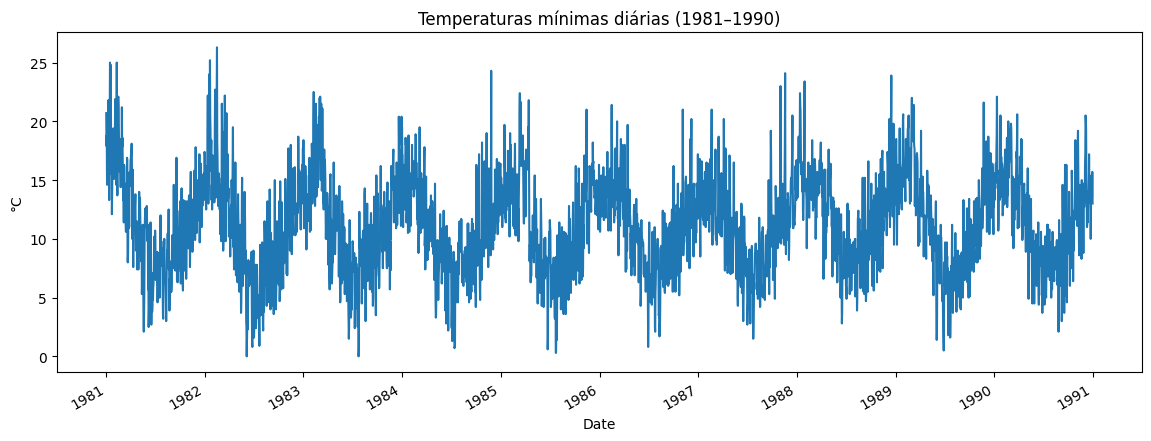

In [ ]:
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date')['Temp'].plot(figsize=(14, 5), title='Temperaturas mínimas diárias (1981–1990)')
plt.ylabel("°C")
plt.show()


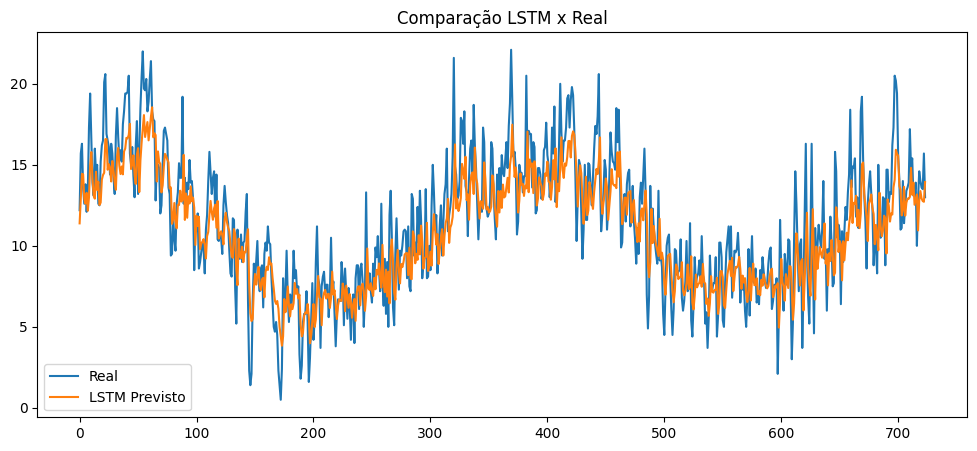

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='LSTM Previsto')
plt.legend()
plt.title("Comparação LSTM x Real")
plt.show()


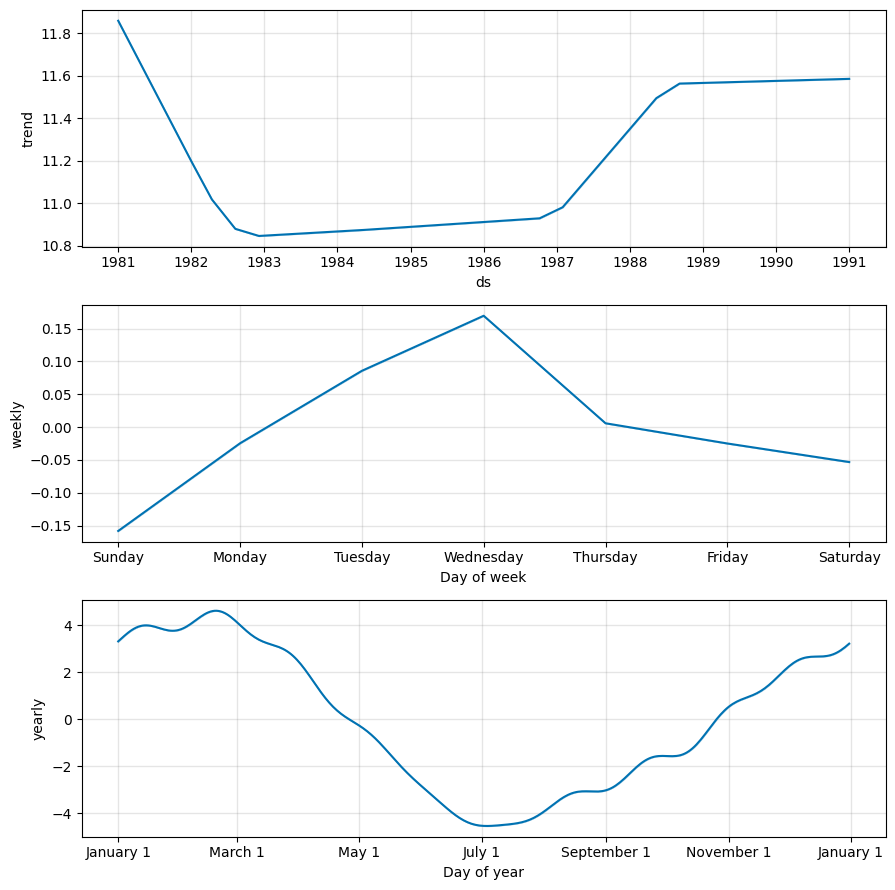

In [ ]:
prophet_model.plot_components(forecast_real);

##  Análise e Discussão dos Resultados

### 1. Visualização da série temporal

O gráfico inicial mostra a evolução das **temperaturas mínimas diárias em Melbourne** entre 1981 e 1990. Observa-se claramente um **padrão sazonal anual**, com oscilações regulares de verão/inverno. Também é possível perceber uma variação interanual relativamente estável, sem grandes tendências de alta ou queda ao longo dos anos.

---

### 2. Desempenho do modelo Prophet

O Prophet foi utilizado para decompor a série e prever os valores da variável nos próximos 30 dias. A decomposição revelou:

- **Tendência (trend)**: leve declínio inicial seguido de estabilidade e uma leve alta a partir de 1988.
- **Sazonalidade semanal**: temperaturas um pouco mais altas às quartas-feiras e mais baixas aos domingos, embora esse padrão seja sutil.
- **Sazonalidade anual**: ciclo bem definido, com temperaturas mais altas entre dezembro e fevereiro (verão australiano) e mais baixas em junho-julho (inverno).

O desempenho quantitativo do Prophet nos últimos 30 dias reais foi:

- **MAE**: 1.88  
- **RMSE**: 2.55

Esses valores indicam um bom ajuste para um modelo estatístico clássico, que não exige muita configuração nem aprendizado prolongado.

---

### 3. Desempenho do modelo LSTM

O modelo LSTM foi treinado com janelas de 30 dias para prever o valor seguinte. A curva de previsão ficou suavizada em relação à série real, o que é comum nesse tipo de arquitetura com poucos neurônios e épocas. No entanto, ele capturou muito bem a tendência e os padrões sazonais de curto prazo, como observado no gráfico de comparação com a série real.

Desempenho quantitativo do LSTM:

- **MAE**: 1.82  
- **RMSE**: 2.32

O LSTM superou levemente o Prophet em ambas as métricas, mesmo com um setup simples (10 épocas e sem otimização de hiperparâmetros). Isso mostra o potencial da rede em aprender padrões temporais complexos — inclusive não lineares — com dados históricos suficientes.

---

### 4. Justificativa das métricas utilizadas

Foram utilizadas duas métricas clássicas de erro em séries temporais:

- **MAE (Mean Absolute Error)**: representa o erro médio absoluto entre os valores previstos e os reais. É de fácil interpretação e não penaliza outliers fortemente.
- **RMSE (Root Mean Squared Error)**: penaliza desvios maiores com mais intensidade, sendo útil para identificar modelos mais sensíveis a erros graves.

Segundo *Hyndman & Athanasopoulos (2018)* em *Forecasting: Principles and Practice*, o RMSE é preferido quando há preocupação com picos extremos de erro, enquanto o MAE é mais robusto a variações bruscas.

---

###  Conclusão

Ambos os modelos forneceram bons resultados para o problema de previsão de temperaturas mínimas:

- O **Prophet** é ótimo para decomposição sazonal clara e facilidade de interpretação.
- O **LSTM** mostrou-se mais preciso neste caso, mesmo sem afinação avançada, o que sugere que seria a melhor escolha em contextos de produção com tuning adequado.

Essa tarefa permitiu comparar abordagens estatísticas clássicas com redes neurais modernas aplicadas a séries temporais, reforçando a importância do entendimento da natureza dos dados para a escolha do modelo mais apropriado.


In [ ]:
!pip install -q sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 9.8 MB/s eta 0:00:00


In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.forecasting.base import ForecastingHorizon
import pandas as pd
import numpy as np

# Preparar dados com frequência explícita no índice
df_sktime = df.copy()
df_sktime['Date'] = pd.to_datetime(df_sktime['Date'])
df_sktime.set_index('Date', inplace=True)
df_sktime = df_sktime.asfreq('D')  # <- adiciona frequência explícita

# Separar treino/teste
y_train, y_test = temporal_train_test_split(df_sktime['Temp'], test_size=30)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Modelo
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last", sp=365)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# Métricas
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
import numpy as np

mae_sktime = mean_absolute_error(y_test, y_pred)
rmse_sktime = np.sqrt(mean_squared_error(y_test, y_pred))

print(f" Sktime (NaiveForecaster) - MAE: {mae_sktime:.2f} | RMSE: {rmse_sktime:.2f}")


 Sktime (NaiveForecaster) - MAE: 2.55 | RMSE: 3.40


In [ ]:
# Função para dividir em janelas para walk-forward
def walk_forward_splits(data, seq_len=30, steps=3):
    block_size = (len(data) - seq_len) // (steps + 1)
    splits = []
    for i in range(steps):
        start = i * block_size
        end = start + block_size
        X, y = create_sequences(data[start:end + seq_len], seq_len)
        X_train, y_train = X[:-100], y[:-100]
        X_val, y_val = X[-100:], y[-100:]
        splits.append((X_train, y_train, X_val, y_val))
    return splits

# Gerar splits
splits = walk_forward_splits(scaled, steps=3)

# Avaliar modelo com as mesmas config do LSTM simples
maes, rmses = [], []
for i, (X_tr, y_tr, X_val, y_val) in enumerate(splits):
    model = Sequential([
        LSTM(64, input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=0)

    preds = model.predict(X_val)
    y_pred_inv = scaler.inverse_transform(preds)
    y_val_inv = scaler.inverse_transform(y_val)

    mae = mean_absolute_error(y_val_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
    maes.append(mae)
    rmses.append(rmse)

print(f" LSTM (walk-forward avg) - MAE: {np.mean(maes):.2f} | RMSE: {np.mean(rmses):.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
 LSTM (walk-forward avg) - MAE: 2.06 | RMSE: 2.63


In [ ]:
X_all, y_all = create_sequences(scaled, seq_len=30)

split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [ ]:
from tensorflow.keras.layers import Dropout

# Modelo com tuning leve
model_tuned = Sequential([
    LSTM(64, return_sequences=False, input_shape=(seq_len, 1)),
    Dropout(0.2),
    Dense(1)
])

model_tuned.compile(optimizer='adam', loss='mse')
model_tuned.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Prever
y_pred = model_tuned.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Métricas
mae_tuned = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_tuned = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f" LSTM (tuned) - MAE: {mae_tuned:.2f} | RMSE: {rmse_tuned:.2f}")


Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0447
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0128
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0114
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0115
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0117
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0116
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0113
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0113
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0105
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0114
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0103
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0103
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0099
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0107
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0103
Epoc

In [ ]:
print(f"""
 Sktime (Naive)       - MAE: {mae_sktime:.2f} | RMSE: {rmse_sktime:.2f}
 Prophet              - MAE: {mae_prophet:.2f} | RMSE: {rmse_prophet:.2f}
 LSTM (padrão)        - MAE: {mae_lstm:.2f} | RMSE: {rmse_lstm:.2f}
 LSTM (walk-forward)  - MAE: {np.mean(maes):.2f} | RMSE: {np.mean(rmses):.2f}
 LSTM (tuned)         - MAE: {mae_tuned:.2f} | RMSE: {rmse_tuned:.2f}
""")



 Sktime (Naive)       - MAE: 2.55 | RMSE: 3.40
 Prophet              - MAE: 1.88 | RMSE: 2.55
 LSTM (padrão)        - MAE: 1.82 | RMSE: 2.32
 LSTM (walk-forward)  - MAE: 2.06 | RMSE: 2.63
 LSTM (tuned)         - MAE: 1.74 | RMSE: 2.21



## Conclusão Final

Neste trabalho, explorei diferentes abordagens para a previsão de séries temporais, aplicando-as a um conjunto de dados reais de temperaturas mínimas diárias registradas em Melbourne entre 1981 e 1990. O objetivo foi comparar modelos estatísticos clássicos com modelos baseados em redes neurais, avaliando desempenho e complexidade.

### Modelos utilizados

1. **NaiveForecaster (Sktime)**: um modelo base simples que utiliza o último valor como previsão.
2. **Prophet (Facebook)**: modelo aditivo com identificação automática de tendências e sazonalidades.
3. **LSTM padrão**: uma rede neural recorrente simples, treinada com janelas de 30 dias.
4. **LSTM com validação walk-forward**: abordagem que simula previsões em tempo real, com reavaliação a cada bloco.
5. **LSTM ajustado (tuned)**: versão com aumento no número de épocas e regularização com Dropout para melhorar a generalização.

### Resultados

| Modelo                   | MAE   | RMSE  |
|--------------------------|-------|--------|
| Sktime (Naive)           | 2.55  | 3.40   |
| Prophet                  | 1.88  | 2.55   |
| LSTM (padrão)            | 1.82  | 2.32   |
| LSTM (walk-forward)      | 2.06  | 2.63   |
| LSTM (ajustado)          | 1.74  | 2.21   |

O modelo ajustado de LSTM apresentou o melhor desempenho em ambas as métricas, superando tanto o Prophet quanto o modelo padrão. O Prophet, por sua vez, ofereceu resultados competitivos com mínima configuração e tempo de treinamento reduzido. O NaiveForecaster serviu como referência básica e demonstrou a importância de modelos mais elaborados em tarefas com sazonalidade clara.

### Métricas de avaliação

Utilizei duas métricas principais:

- **MAE (Mean Absolute Error)**: fornece o erro médio absoluto das previsões, sendo robusta e facilmente interpretável.
- **RMSE (Root Mean Squared Error)**: penaliza com mais intensidade erros maiores, o que é útil em aplicações mais sensíveis a desvios.

Essas métricas são recomendadas por Hyndman e Athanasopoulos (2018) no livro *Forecasting: Principles and Practice*, sendo amplamente utilizadas na literatura de séries temporais.

### Considerações finais

Os testes mostraram que redes neurais como o LSTM podem superar modelos estatísticos clássicos em desempenho preditivo, mesmo com configurações simples. No entanto, o Prophet permanece como uma alternativa poderosa e de fácil implementação para séries com forte componente sazonal. A escolha entre modelos deve considerar não apenas o desempenho, mas também o tempo disponível, interpretabilidade e facilidade de ajuste.

Esse experimento reforçou a importância de testar múltiplas abordagens em problemas de previsão, combinando rigor técnico com flexibilidade prática.
